In [1]:
# add shortcut to drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
from datetime import datetime

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import cv2
import matplotlib.pyplot as plt 
from sklearn.metrics import r2_score

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
PATH = Path("/content/drive/MyDrive/boneage-300/")

# Data

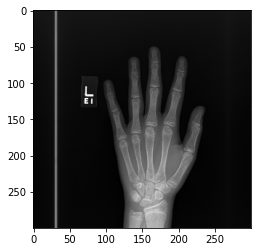

In [4]:
path = PATH/"10040.png"
im = cv2.imread(str(path))
plt.imshow(im, cmap='gray')

In [5]:
im = cv2.imread(str(path))
im.shape

(300, 300, 3)

In [6]:
df = pd.read_csv(PATH/"boneage-training-dataset.csv")
train = df.sample(frac=0.8, random_state=3).copy()
valid = df.drop(train.index).copy()

In [7]:
df.head()      # data
print(len(train),len(valid))
train.head()    # sample

10089 2522


,id,boneage,male
6067,8304,150,True
466,1903,123,False
5556,7739,168,True
4386,6430,162,True
498,1939,138,True


# DataSet

In [8]:
class MyDataSet(Dataset):
    """
    Basic Images DataSet
    Args:
    dataframe with data: image_id, label
    image_path
    """
    def __init__(self, df, transform=False):
        self.image_path = PATH
        self.df = df
        self.transform = transform
        if transform == True:
            self.tfms = A.Compose([
           A.ShiftScaleRotate(shift_limit = 0.04, 
                              scale_limit = 0.04, 
                              rotate_limit = 10,
                              border_mode = cv2.BORDER_CONSTANT,
                              value = 0.0,
                              p=0.5),
           A.VerticalFlip(p=0.5),
           A.HorizontalFlip(p=0.5),
           A.RandomBrightnessContrast(p=0.5),
           A.Normalize(mean = (0.485, 0.456, 0.406), 
                        std = (0.229, 0.224, 0.225)),
           ToTensorV2()
                ])
        else:
            self.tfms = A.Compose([
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2()
                ]) 
        
    def __len__(self):
        return self.df.shape[0]         

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx]["id"]
        path = self.image_path/"{}.png".format(image_id)
        x = cv2.imread(str(path))
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.tfms(image=x)["image"]    
        y = self.df.iloc[idx]["boneage"]
        y = torch.tensor([y]).float()
        return x, y

In [9]:
# Create datasets
train_ds = MyDataSet(train, transform=False)
valid_ds = MyDataSet(valid, transform=False)

In [10]:
# Create DataLoaders
batch_size = 64
num_workers = 0

train_dl = torch.utils.data.DataLoader(train_ds, 
                                      batch_size = batch_size,
                                      shuffle = True, 
                                      num_workers=num_workers)
valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                      batch_size = batch_size,
                                      shuffle = False, 
                                      num_workers=num_workers)

In [ ]:
## Iterating through a Dataloader object

print(len(train_dl))
x,y = next(iter(train_dl))
x.shape, y.shape

# Device

In [11]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")

-Type of precessor to be used: 'gpu'
Thu Nov 10 16:42:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                   

# Model

In [12]:
#  Create class for CNN with its corresponding forward method
class Net(nn.Module):
    
# .Network architecture
    def __init__(self):
        super(Net, self).__init__()
        
# ..layers for feature extraction
        self.features_0 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)                                   
        )
        self.features_1 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.features_2 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

# ..layer to reduce output to desired size
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
# ..layers for classification
        self.classifier = nn.Sequential(
            nn.Linear(6*6*256, 4096), nn.ReLU(inplace=True),
#            nn.Linear(4096, 4096), nn.ReLU(inplace=True),
            nn.Linear(4096, 1)
        )

# .Forward function
    def forward(self, x):

# ..apply the feature extractor in the input
        x = self.features_0(x)
        x = self.features_1(x)
        x = self.features_2(x)
        
# ..apply adaptative average pooling with output 1x1
        x = self.avgpool(x)
    
# ..squeeze the three spatial dimensions in one
        x = torch.flatten(x, 1)
        
# ..classify the images
        x = self.classifier(x)
        return x

In [13]:
# Instantiate model
model = Net()

# Load model into GPU
model = model.to(device)

In [14]:
p = sum(p.numel() for p in model.parameters())
p

41504129

In [15]:
#model
#model.features_0

# Optimizer and Loss function

In [16]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Type of Loss Function
loss_func = nn.L1Loss(reduction='mean')

# Validation loss per epoch 

In [17]:
def valid_epoch_reg(data_loader, model, loss_type, device):
    """
    Input:
    - data_loader: torch DataLoader previously created
    - model:       torch model previously trained
    - loss_type:   loss function previously created/instantiated
    - device: 'gpu' or 'cpu'
    
    Output:
    - Mean loss function over the entire data set
    """
# Put model in evaluation mode
    model.eval()
    loss_fun = 0.
    n_points = 0

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
        for i, (xx, yy) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)
        
# .compute loss function
            batch_size = len(yy)
            loss = loss_type(yy_pred, yy)
            loss_fun += batch_size*loss.item()
        
# .number of points used after the ith mini-batch
            n_points += batch_size
    return loss_fun/n_points

def dataset_r2(data_loader, model, device):
    """
    Input:
    - data_loader: torch DataLoader previously created
    - model:       torch model previously trained
    - device: 'gpu' or 'cpu'
    
    Output:
    - R2 score for the given data set
    """
# Put model in evaluation mode
    model.eval()
    ss_tot = 0.0
    ss_res = 0.0

# Loop over mini batches (no gradients need to be computed)
    with torch.no_grad():
    # .Find mean of y and number of observations
        y_mean = 0.0
        n_points = 0
        for i, (xx, yy) in enumerate(data_loader, start=1):
            batch_size = len(yy)
            y_mean += yy.sum()
            n_points += batch_size
        y_mean = y_mean/float(n_points)

    # .Find total sum of squares and residuals
        for i, (xx, yy) in enumerate(data_loader, start=1):
            xx = xx.to(device)
            yy = yy.to(device)
            yy_pred = model(xx)

            ss_tot += torch.square(yy - y_mean).sum()
            ss_res += torch.square(yy - yy_pred).sum()

        r2_score = 1.0 - (ss_res/ss_tot)
    return r2_score.item()

# Training loop

In [ ]:
# .Loop Over Number of Epochs
iteration = 0
best_loss_valid = np.inf
epochs = 10
path_loss = {}
data_epoch = []

for n_epoch in range(epochs):
# ..Loop Over Mini-batches
    for ibatch, (xx, yy_true) in enumerate(train_dl, start=1):
        
    #...Compute Train Loss (over minibatch)
        start = datetime.now()
        model.train()
        xx = xx.to(device)
        yy_true = yy_true.to(device)
        yy_pred = model(xx)
        loss = loss_func(yy_pred, yy_true)
        path_loss['train_loss'] = loss.item()
        
    #...Compute Gradients
        optimizer.zero_grad()
        loss.backward()

    #...Update Weights 
        optimizer.step()
        iteration += 1
        
    #...Compute Validation Loss
        path_loss['valid_loss'] = valid_epoch_reg(valid_dl, 
                                                   model, 
                                                   loss_func, 
                                                   device)
        
        r2_train = r2_score(yy_true.detach().cpu().numpy(),yy_pred.detach().cpu().numpy())
        r2_valid = dataset_r2(valid_dl, model, device)
        end = datetime.now()
        
        if n_epoch % 100 == 0:
            print(n_epoch,iteration, "{:.4f}".format(path_loss['train_loss']), "{:.4f}".format(path_loss['valid_loss']),
                 "Train R2 = {:.3f}".format(r2_train), "Valid R2 = {:.3f}".format(r2_valid)
                 ,"---End of step", (end - start))
    
    #...File with the loss and r2 per epoch----------------
        data_epoch.append([n_epoch, iteration, path_loss['train_loss'], path_loss['valid_loss'],
                           r2_train, r2_valid])

0 1 129.1194 126.7214 Train R2 = -7.204 Valid R2 = -9.550 ---End of step 0:21:48.102709
0 2 128.0447 126.0547 Train R2 = -12.330 Valid R2 = -9.449 ---End of step 0:00:54.096603
0 3 124.0795 125.2568 Train R2 = -10.077 Valid R2 = -9.330 ---End of step 0:00:53.400370
0 4 124.5456 124.3159 Train R2 = -9.589 Valid R2 = -9.190 ---End of step 0:00:53.149838
0 5 129.7796 123.2170 Train R2 = -8.815 Valid R2 = -9.028 ---End of step 0:00:53.178250
0 6 123.5558 121.9436 Train R2 = -9.267 Valid R2 = -8.843 ---End of step 0:00:53.004604
0 7 115.9919 120.4736 Train R2 = -7.346 Valid R2 = -8.631 ---End of step 0:00:53.073646
0 8 125.5406 118.7843 Train R2 = -8.737 Valid R2 = -8.390 ---End of step 0:00:53.755441
0 9 120.8472 116.8506 Train R2 = -8.637 Valid R2 = -8.119 ---End of step 0:00:53.388481
0 10 118.1714 114.6436 Train R2 = -5.949 Valid R2 = -7.816 ---End of step 0:00:52.818868
0 11 116.1684 112.1329 Train R2 = -9.050 Valid R2 = -7.477 ---End of step 0:00:52.630425
0 12 109.4738 109.2953 Train

In [ ]:
filename = "output/net_1_model.csv" 
columns = ['Epoch', 'iteration','Train_loss', 'Val_loss', 'Train_score', 'Val_score'] 
df_out = pd.DataFrame(data=data_epoch, columns=columns) 
#df_out.to_csv(filename, index=False)
df_out.tail(20)

In [ ]:
df_out.plot( 
        y=['Train_loss', 'Val_loss'], 
        figsize=(8,6))
plt.show()